In [41]:
#%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset
import os

In [45]:
import importlib
importlib.reload(dataset)

MAXLEN = 50
BATCH_SIZE = 128  # 512
files = ['texts/' + f for f in os.listdir('texts/')]  # short_table.txt', 'texts/treasure_island.txt', 'texts/ahava.txt', 'texts/rambam_mamre.txt', 'texts/ali_baba.txt', 'texts/bible.txt']

data = dataset.load_file(BATCH_SIZE, 0.1, maxlen=MAXLEN, filenames=files)


In [46]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 256  # larger -> quicker opening. knee at 1024
UNITS = 512

inp = tf.keras.Input(shape=(data.input_texts.shape[1],), batch_size=BATCH_SIZE)

embedding = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)

rnn_common = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.5), merge_mode='sum', name='Common_RNN')(embedding)

rnn_niqqud = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum', name='Niqqud_RNN')(rnn_common)

dense_1 = layers.Dense(UNITS, activation='relu', kernel_regularizer=l2(5e-5), kernel_initializer='he_uniform')(rnn_niqqud)

add = layers.add([rnn_common, dense_1])

norm_1 = layers.BatchNormalization()(add)

output_niqqud = layers.Dense(data.niqqud_texts.shape[1], name='N_raw')(norm_1)
output_niqqud = tf.keras.layers.Softmax(name='N')(output_niqqud)

rnn_dagesh = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.2), merge_mode='sum', name='Dagesh_RNN')(rnn_common) 

output_dagesh = layers.Dense(data.dagesh_texts.shape[1], name='D_raw', kernel_initializer='he_uniform')(rnn_dagesh)
output_dagesh = tf.keras.layers.Softmax(name='D')(output_dagesh)

model = tf.keras.Model(inputs=[inp], outputs=[output_niqqud, output_dagesh])

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

plot_model(model, to_file='model.png')
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(128, 50)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (128, 50, 256)       19200       input_13[0][0]                   
__________________________________________________________________________________________________
Common_RNN (Bidirectional)      (128, 50, 512)       2365440     embedding_12[0][0]               
__________________________________________________________________________________________________
Niqqud_RNN (Bidirectional)      (128, 50, 512)       3151872     Common_RNN[0][0]                 
____________________________________________________________________________________________

In [47]:

# log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def fit(EPOCHS):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
              # tf.keras.callbacks.EarlyStopping(patience=2, verbose=1), # monitor='accuracy', 
              # tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=0, min_lr=0.0001), # monitor='loss', 
              # tensorboard_callback,
          ]
    )

history = fit(EPOCHS=1)

Train on 132249 samples, validate on 14695 samples
132249/132249 [==============================] - 215s 2ms/sample - loss: 0.5017 - N_loss: 0.3449 - D_loss: 0.1215 - N_accuracy: 0.8810 - D_accuracy: 0.9556 - val_loss: 0.2506 - val_N_loss: 0.1645 - val_D_loss: 0.0604 - val_N_accuracy: 0.9438 - val_D_accuracy: 0.9764


In [48]:
history = fit(EPOCHS=1)

Train on 132249 samples, validate on 14695 samples
132249/132249 [==============================] - 193s 1ms/sample - loss: 0.2164 - N_loss: 0.1445 - D_loss: 0.0506 - N_accuracy: 0.9504 - D_accuracy: 0.9804 - val_loss: 0.1694 - val_N_loss: 0.1145 - val_D_loss: 0.0368 - val_N_accuracy: 0.9610 - val_D_accuracy: 0.9861uracy: 0.9497 


In [51]:
history = fit(EPOCHS=1)

Train on 132249 samples, validate on 14695 samples
132249/132249 [==============================] - 193s 1ms/sample - loss: 0.1186 - N_loss: 0.0819 - D_loss: 0.0241 - N_accuracy: 0.9716 - D_accuracy: 0.9908 - val_loss: 0.1239 - val_N_loss: 0.0865 - val_D_loss: 0.0253 - val_N_accuracy: 0.9715 - val_D_accuracy: 0.9907


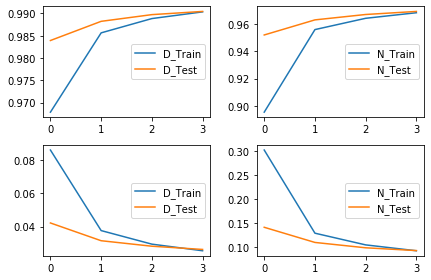

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]  # plt.subplot(1, 4, i)
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        # p.title('Model ' + t + ' ' + v)
        # p.ylabel(v)
        # p.xlabel('Epoch')
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [22]:
# model = tf.keras.Model(inputs=[inp], outputs=[tf.keras.layers.Softmax()(output_niqqud), tf.keras.layers.Softmax()(output_dagesh)])

def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    [actual_niqqud, actual_dagesh] = dataset.from_categorical(model.predict(batch))
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for a, e in zip(actual, expected):
        print(a)
        print(e)
        print()

print_predictions(1)

וְשָלַח לִקְנוֹת עוֹד אֲפִלּוּ יֵש לְפָנָיו עוֹד מִמַּה שֶּהֵכִין בַּתְּחִלָּה
וְשָלַח לִקְנוֹת עוֹד אֲפִלּוּ יֵש לְפָנָיו עוֹד מִמַּה שֶהֵכִין בַּתְחִלָּה

דָּמִים: שֶחֶזְקָתוֹ שֶבָּא עַל הַמָּמוֹן בִּלְבָד, לְפִי שְאֵין רֹב
דָּמִים: שֶחֶזְקָתוֹ שֶבָּא עַל הַמָּמוֹן בִּלְבָד, לְפִי שְאֵין רֹב

אַשְרֵי שֶיֶאחֹז וְנָפַּץ אֶת-עֹלְלֶיךָ אֶל-הַסֶּלַע לְדָוִד אוֹדְךָ
אַשְרֵי שֶיֹּאחֵז וְנִפֵּץ אֶת-עֹלָלַיִךְ אֶל-הַסָּלַע לְדָוִד אוֹדְךָ

הָאָרֶץ, וְהֶן הַנִּקְרָאִין פְּרָעוֹת--אִם יְכוּלִין לְקַבַּל מַעְזֵבָה
הָאָרֶץ, וְהֶן הַנִּקְרָאִין פְּרָעוֹת--אִם יְכוּלִין לְקַבַּל מַעְזֵבָה

לָהּ שִבְעָה נְקִיִים הָרִאשוֹנִים כֵּיוָן שֶהֻסְּחָה דַּעְתָּהּ מִמֶּנּוּ אֶלָּא
לָה שִבְעָה נְקִיִים הָרִאשוֹנִים כֵּיוָן שֶהִסִּחָה דַעְתָּהּ מִמֶּנוּ אֶלָּא

הָיָה שָם זָקֵן חָכָם, מַעְמִידִין חָכָם; לֹא הָיָה שָם לֹא זָקֵן וְלֹא
הָיָה שָם זָקֵן חָכָם, מַעְמִידִין חָכָם; לֹא הָיָה שָם לֹא זָקֵן וְלֹא

עוֹשִין בַּשַּבָּת. וְכֵן מֻתָּר לָאָדָם לְהַשְכִּיר כַּרְמוֹ אוֹ שָדֵהוּ
עוֹשִין בַּשַּבָּת. וְכֵן מֻתָּר לָ

In [16]:
# model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [ ]:
print(history.history['val_accuracy'])

In [ ]:
%tensorboard --logdir logs\fit